# Student Retention Predictor
> Predicting college dropout risk using U.S. Department of Education data

## Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Load and Preview Data

In [14]:
df = pd.read_csv('../data/college_scorecard_apr2025.csv', low_memory=False)
df.shape
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## Column Selection and Cleaning

In [15]:
cols = [
    'PCTPELL',         # Percentage of undergraduates who receive a Pell Grant
    'ADM_RATE',        # Admission rate
    'REGION',          # Region (IPEDS)
    'LOCALE',          # Locale of institution
    'RET_FT4'          # Target variable: First-time, full-time student retention rate at four-year institutions
]

# region 0: U.S. Service Schools
# region 1: New England (CT, ME, MA, NH, RI, VT)
# region 2: Mid East (DE, DC, MD, NJ, NY, PA)
# region 3: Great Lakes (IL, IN, MI, OH, WI)
# region 4: Plains (IA, KS, MN, MO, NE, ND, SD)
# region 5: Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)
# region 6: Southwest (AZ, NM, OK, TX)
# region 7: Rocky Mountains (CO, ID, MT, UT, WY)
# region 8: Far West (AK, CA, HI, NV, OR, WA)
# region 9: Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)

# Select relevant columns and drop rows with NaN values
df = df[cols].dropna()
# Keep only rows where REGION is between 1 and 8
df = df[(df['REGION'] >= 1) & (df['REGION'] <= 8)]

## Create Binary Target

In [16]:
# if retention rate is above 0.70, it is a success
# otherwise, it is a failure
df['TARGET'] = (df['RET_FT4'] > 0.70).astype(int)

## Convert Categorical Data

In [17]:
# group LOCALE values into broader categories
def simplify_locale(val):
    if val in [11, 12, 13]:
        return 'City'
    elif val in [21, 22, 23]:
        return 'Suburb'
    elif val in [31, 32, 33]:
        return 'Town'
    elif val in [41, 42, 43]:
        return 'Rural'
    else:
        return 'Unknown'
    
# apply the function to the LOCALE column
df['LOCALE_GROUPED'] = df['LOCALE'].apply(simplify_locale)

## Exploratory Data Analysis

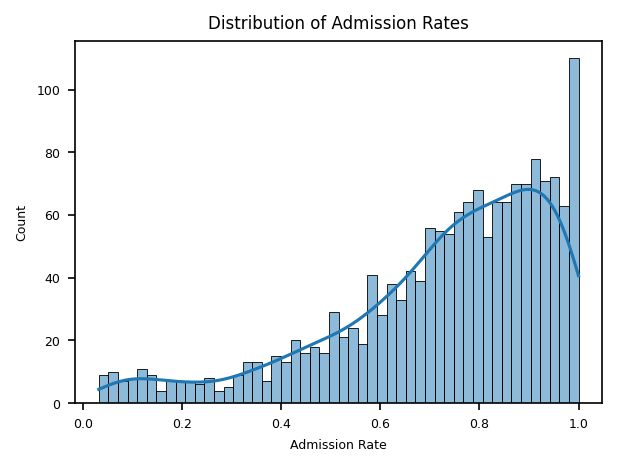

In [18]:
plt.figure(figsize=(4, 3), dpi=150, layout='constrained')
plt.title("Distribution of Admission Rates", fontsize=8)
plt.xlabel("Admission Rate", fontsize=6)
plt.ylabel("Count", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.histplot(data=df, x='ADM_RATE', bins=50, kde=True)
plt.show()

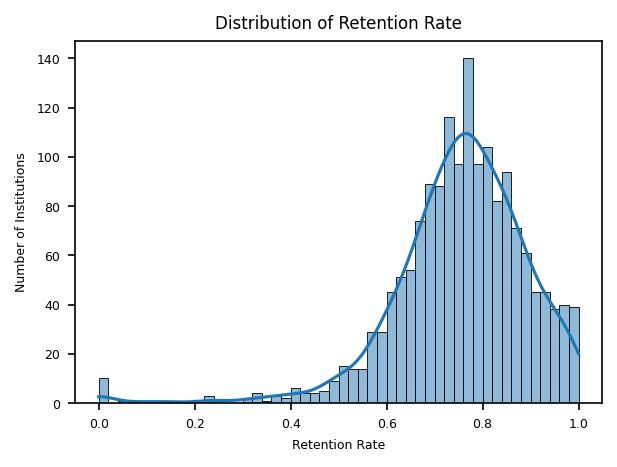

In [19]:
plt.figure(figsize=(4, 3), dpi=150, layout='constrained')
plt.title("Distribution of Retention Rate", fontsize=8)
plt.xlabel("Retention Rate", fontsize=6)
plt.ylabel("Number of Institutions", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.histplot(df['RET_FT4'], bins=50, kde=True)
plt.show()

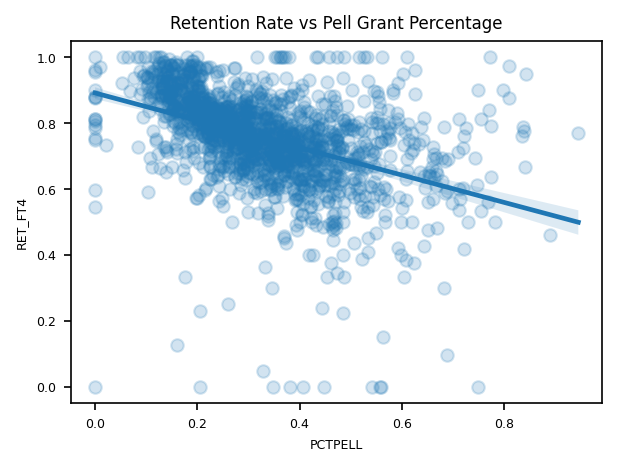

In [20]:
plt.figure(figsize=(4, 3), dpi=150, layout='constrained')
plt.title("Retention Rate vs Pell Grant Percentage", fontsize=8)
plt.xlabel("Pell Grant Percentage", fontsize=6)
plt.ylabel("Retention Rate", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.regplot(x='PCTPELL', y='RET_FT4', data=df, scatter_kws={'alpha':0.2})
plt.show()

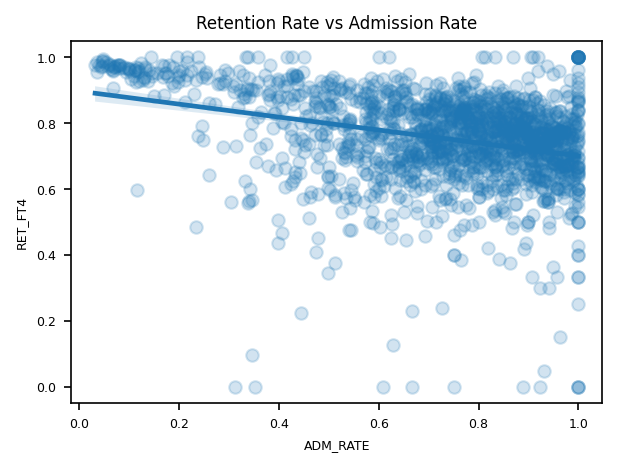

In [21]:
plt.figure(figsize=(4, 3), dpi=150, layout='constrained')
plt.title("Retention Rate vs Admission Rate", fontsize=8)
plt.xlabel("Admission Rate", fontsize=6)
plt.ylabel("Retention Rate", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.regplot(x='ADM_RATE', y='RET_FT4', data=df, scatter_kws={'alpha':0.2})
plt.show()

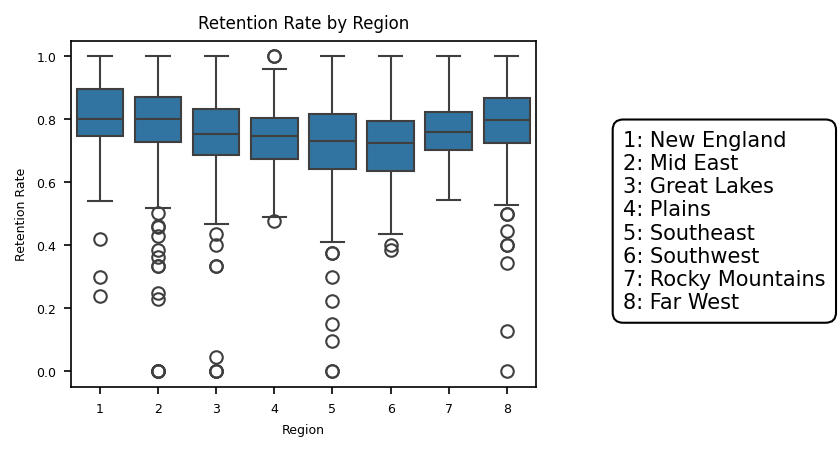

In [22]:
plt.figure(figsize=(4, 3), dpi=150)
plt.title("Retention Rate by Region", fontsize=8)
plt.xlabel("Region", fontsize=6)
plt.ylabel("Retention Rate", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.boxplot(data=df, x='REGION', y='RET_FT4')

# Create label text
region_text = "\n".join([
    "1: New England",
    "2: Mid East",
    "3: Great Lakes",
    "4: Plains",
    "5: Southeast",
    "6: Southwest",
    "7: Rocky Mountains",
    "8: Far West"
])

plt.text(
    x=9, y=0.2, s=region_text, fontsize=10,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black')
)
plt.show()

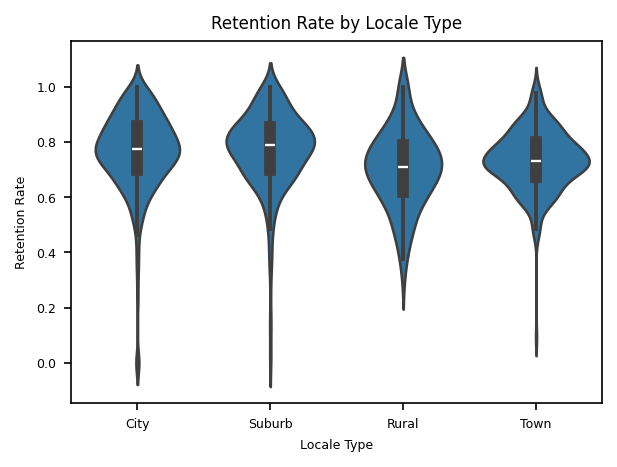

In [23]:
plt.figure(figsize=(4, 3), dpi=150, layout='constrained')
plt.title("Retention Rate by Locale Type", fontsize=8)
plt.xlabel("Locale Type", fontsize=6)
plt.ylabel("Retention Rate", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

sns.violinplot(data=df, x='LOCALE_GROUPED', y='RET_FT4')
plt.show()